In [0]:
#я не торч просто дунул
import torch

import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [0]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

0it [00:00, ?it/s]

170500096it [00:06, 28006331.29it/s]                               


Files already downloaded and verified


In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [0]:
len(y_train), len(y_test)

(50000, 10000)

In [0]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [0]:
X_train /= 255.
X_test /= 255.

In [0]:
X_train.shape, X_test.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([10000, 32, 32, 3]))

In [0]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [0]:
def accuracy(y_pred, y_true):
  return (y_pred == y_true).float().mean().data.cpu()

In [0]:
class CIFARNet(torch.nn.Module):
  def __init__(self, n_epochs=1000, lr=1.0e-3, batch_size=100, save_history=False):
    super(CIFARNet, self).__init__()
    
    self.n_epochs = n_epochs
    self.lr = lr
    self.batch_size = batch_size
    self.save_history = save_history
    
    self.bn0 = torch.nn.BatchNorm2d(num_features=3)
    
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.act1 = torch.nn.ReLU()
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.act2 = torch.nn.ReLU()
    self.bn2 = torch.nn.BatchNorm2d(num_features=32)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.act3 = torch.nn.ReLU()
    self.bn3 = torch.nn.BatchNorm2d(num_features=64)
    
    self.fc1 = torch.nn.Linear(8 * 8 * 64, 256)
    self.act4 = torch.nn.ReLU()
    
    self.fc2 = torch.nn.Linear(256, 64)
    self.act5 = torch.nn.Tanh()
    self.bn4 = torch.nn.BatchNorm1d(64)
    
    self.fc3 = torch.nn.Linear(64, 10)
    
    self.sm = torch.nn.Softmax(dim=1)
    
  def forward(self, x):
    x = self.bn0(x)
    
    x = self.conv1(x)
    x = self.act1(x)
    x = self.bn1(x)
    x = self.pool1(x)
    
    x = self.conv2(x)
    x = self.act2(x)
    x = self.bn2(x)
    x = self.pool2(x)
    
    x = self.conv3(x)
    x = self.act3(x)
    x = self.bn3(x)
    
    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    x = self.fc1(x)
    x = self.act4(x)
    x = self.fc2(x)
    x = self.act5(x)
    x = self.fc3(x)
    return x
  
  def fit(self, x, y, x_test=None, y_test=None):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(device)
    if self.save_history:
      self.test_accuracy_history_ = []
      self.test_loss_history_ = []

      x_test = x_test.to(device)
      y_test = y_test.to(device)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), self.lr)
      
    for _ in range(self.n_epochs):
      shuffled_indexes = np.random.permutation(x.shape[0])
        
      for start_index in range(0, x.shape[0], self.batch_size):
        self.train()
        x_batch = x[shuffled_indexes[start_index:start_index + self.batch_size]].to(device)
        y_batch = y[shuffled_indexes[start_index:start_index + self.batch_size]].to(device)
          
        optimizer.zero_grad()
        y_output = self.forward(x_batch)
        loss_value = loss(y_output, y_batch)
        loss_value.backward()
        optimizer.step()
          
      if self.save_history:
        self.eval()
        self.test_accuracy_history_.append(accuracy(self.predict(x_test),
                                                      y_test).numpy())
        self.test_loss_history_.append(loss(self.forward(x_test),
                                       y_test).data.cpu().numpy()) 
          
    return self
  
  def predict(self, x):
    self.eval()
    return self.forward(x).argmax(dim=1)
  
  def predict_proba(self, x):
    self.eval()
    return self.sm(self.forward(x))

In [0]:
from google.colab import files
uploaded = files.upload()



Saving accurecies.json to accurecies.json


In [0]:
import io
import json

accuracies = json.load(io.BytesIO(uploaded['accurecies.json']))

In [0]:
uploaded = files.upload()

Saving losses.json to losses.json


In [0]:
uploaded

{'losses.json': b'{\n    "tanh": [\n        1.7237156629562378,\n        1.5588219165802002,\n        1.4582711458206177,\n        1.385316252708435,\n        1.3862457275390625,\n        1.3360451459884644,\n        1.3019304275512695,\n        1.3020225763320923,\n        1.2820340394973755,\n        1.2861744165420532,\n        1.2717006206512451,\n        1.2783193588256836,\n        1.2939201593399048,\n        1.272517204284668,\n        1.2845489978790283,\n        1.284353256225586,\n        1.2903811931610107,\n        1.2961406707763672,\n        1.3093401193618774,\n        1.3053349256515503,\n        1.3152170181274414,\n        1.3293098211288452\n    ],\n    "relu": [\n        1.5995780229568481,\n        1.4720995426177979,\n        1.4321297407150269,\n        1.3802160024642944,\n        1.3396140336990356,\n        1.3054172992706299,\n        1.273160457611084,\n        1.283380150794983,\n        1.2447240352630615,\n        1.2181707620620728,\n        1.197816252

In [0]:
losses = json.load(io.BytesIO(uploaded['losses.json']))

In [0]:
cifar_net = CIFARNet(n_epochs=22, save_history=True)
accuracies['cifar_net'], losses['cifar_net'] = \
    cifar_net.fit(X_train, y_train, X_test, y_test).test_accuracy_history_, \
    cifar_net.test_loss_history_

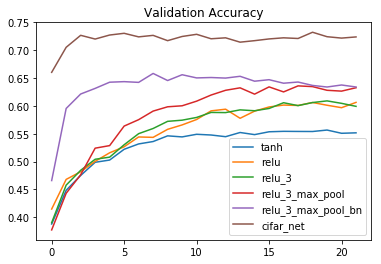

In [0]:
import matplotlib.pyplot as plt
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

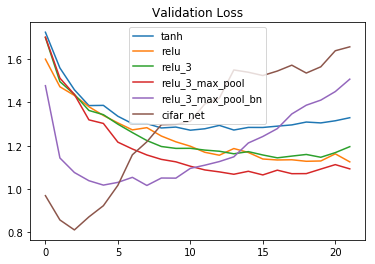

In [0]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');